In [13]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

import pandas as pd
import numpy as np

In [37]:
class UserWallet(User1559):

    sensitivity = 0.05
    
    def expected_time(self, params):
        return 1
    
    def decide_parameters(self, params):
        ma_basefee = sum(params["basefees"]) / len(params["basefees"])
        basefee = params["basefee"]
        max_fee = self.value
        
        if (1 + self.sensitivity) * ma_basefee >= basefee:
            # basefee broadly in line with its average value in the last blocks
            gas_premium = 1 * (10 ** 9)
        else:
            premiums = {
                "fast": 1 * (10 ** 9) + 3 * (basefee - ma_basefee),
                "medium": 1 * (10 ** 9) + 2 * (basefee - ma_basefee),
                "slow": 1 * (10 ** 9) + 1 * (basefee - ma_basefee),
            }
            gas_premium = premiums["fast"]
        
        return {
            "max_fee": max_fee,
            "gas_premium": gas_premium,
            "start_block": self.wakeup_block,
        }

In [38]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)
    ma_window = 5
    basefees = [basefee]

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
            "min_premium": min_premium,
            "basefees": basefees,
        }
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # Record the min premium in the block
        min_premium = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
            "ma_basefee": sum(basefees) / len(basefees),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)
        basefees = basefees[-(ma_window - 1):] + [basefee]

    return (pd.DataFrame(metrics), user_pool, chain)

In [39]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

shares_scenario = [{
    UserWallet: 1
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

In [40]:
df

,block,basefee,users,decided_txs,included_txs,blk_min_premium,blk_avg_gas_price,blk_avg_tip,pool_length,ma_basefee
0,0,1.000000,2431,2138,952,1.000000,2.000000,1.000000,1186,1.000000e+09
1,1,1.124900,2474,2116,952,1.187350,2.312250,1.187350,2350,1.062450e+09
2,2,1.265400,2493,2079,952,1.405900,2.671300,1.405900,3477,1.130100e+09
3,3,1.423448,2557,2080,952,1.660034,3.083483,1.660034,4605,1.203437e+09
4,4,1.601237,2663,2156,952,1.954720,3.555957,1.954720,5809,1.282997e+09
...,...,...,...,...,...,...,...,...,...,...
95,95,14.542617,2465,483,483,1.000000,15.542617,1.000000,7806,1.459146e+10
96,96,14.568612,2617,540,540,1.000000,15.568612,1.000000,7806,1.460778e+10
97,97,14.812636,2543,457,457,1.000000,15.812636,1.000000,7806,1.464109e+10
98,98,14.738017,2487,481,481,1.000000,15.738017,1.000000,7806,1.467347e+10


<AxesSubplot:xlabel='block'>

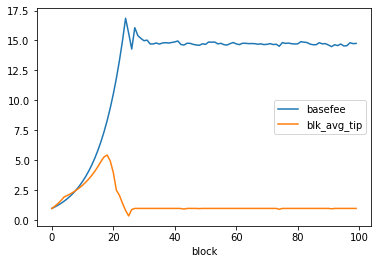

In [41]:
df.plot("block", ["basefee", "blk_avg_tip"])